# Configuration MLFlow pour Credit Scoring

Ce notebook montre comment utiliser MLFlow dans vos expérimentations de machine learning.


## 1. Configuration de l'environnement


In [8]:
import sys
import os
from pathlib import Path

# Ajouter le répertoire parent au path
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

# Imports MLFlow
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

# Imports standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Configuration MLFlow
mlflow.set_tracking_uri("sqlite:///../mlruns/mlflow.db")
print("✅ MLFlow configuré")


✅ MLFlow configuré


In [9]:
# Configuration rapide avec notre utilitaire
from src.utils.notebook_mlflow import quick_mlflow_setup

# Initialiser MLFlow
mlflow_tracker = quick_mlflow_setup("credit-scoring-demo")
print("✅ MLFlow prêt à l'utilisation")


✅ MLFlow configuré - Expérience: credit-scoring-demo
✅ MLFlow prêt à l'utilisation


In [10]:
# Créer des données d'exemple
def create_sample_credit_data():
    """Crée des données de crédit synthétiques"""
    np.random.seed(42)
    n_samples = 2000
    
    # Features réalistes
    age = np.random.normal(35, 10, n_samples)
    income = np.random.lognormal(10, 0.5, n_samples)
    credit_score = np.random.normal(650, 100, n_samples)
    debt_ratio = np.random.beta(2, 5, n_samples)
    employment_years = np.random.exponential(5, n_samples)
    
    # Target avec logique métier
    default_prob = (
        0.1 * (age < 25) +  # Jeunes plus risqués
        0.2 * (income < 30000) +  # Faible revenu
        0.3 * (credit_score < 600) +  # Mauvais crédit
        0.4 * (debt_ratio > 0.4) +  # Fort endettement
        0.2 * (employment_years < 2)  # Peu d'expérience
    )
    
    default_prob = np.clip(default_prob + np.random.normal(0, 0.1, n_samples), 0, 1)
    target = np.random.binomial(1, default_prob)
    
    data = pd.DataFrame({
        'age': age,
        'income': income,
        'credit_score': credit_score,
        'debt_ratio': debt_ratio,
        'employment_years': employment_years,
        'target': target
    })
    
    return data

# Créer les données
data = create_sample_credit_data()
print(f"📊 Données créées: {data.shape}")
print(f"🎯 Taux de défaut: {data['target'].mean():.2%}")
data.head()


📊 Données créées: (2000, 6)
🎯 Taux de défaut: 41.45%


,age,income,credit_score,debt_ratio,employment_years,target
0,39.967142,15715.627250,563.650640,0.149323,9.116329,0
1,33.617357,20490.992220,646.879651,0.172970,6.406361,0
2,41.476885,14820.846849,651.801687,0.539754,0.703126,1
3,50.230299,18883.036063,697.263035,0.206381,4.488261,0
4,32.658466,8545.778237,513.314164,0.554930,5.577559,1


In [11]:
# Préparation des données
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"📊 Données préparées: {X_train.shape[0]} train, {X_test.shape[0]} test")
print(f"🎯 Taux de défaut train: {y_train.mean():.2%}")
print(f"🎯 Taux de défaut test: {y_test.mean():.2%}")


📊 Données préparées: 1600 train, 400 test
🎯 Taux de défaut train: 41.44%
🎯 Taux de défaut test: 41.50%


2025/11/28 15:23:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 15:23:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


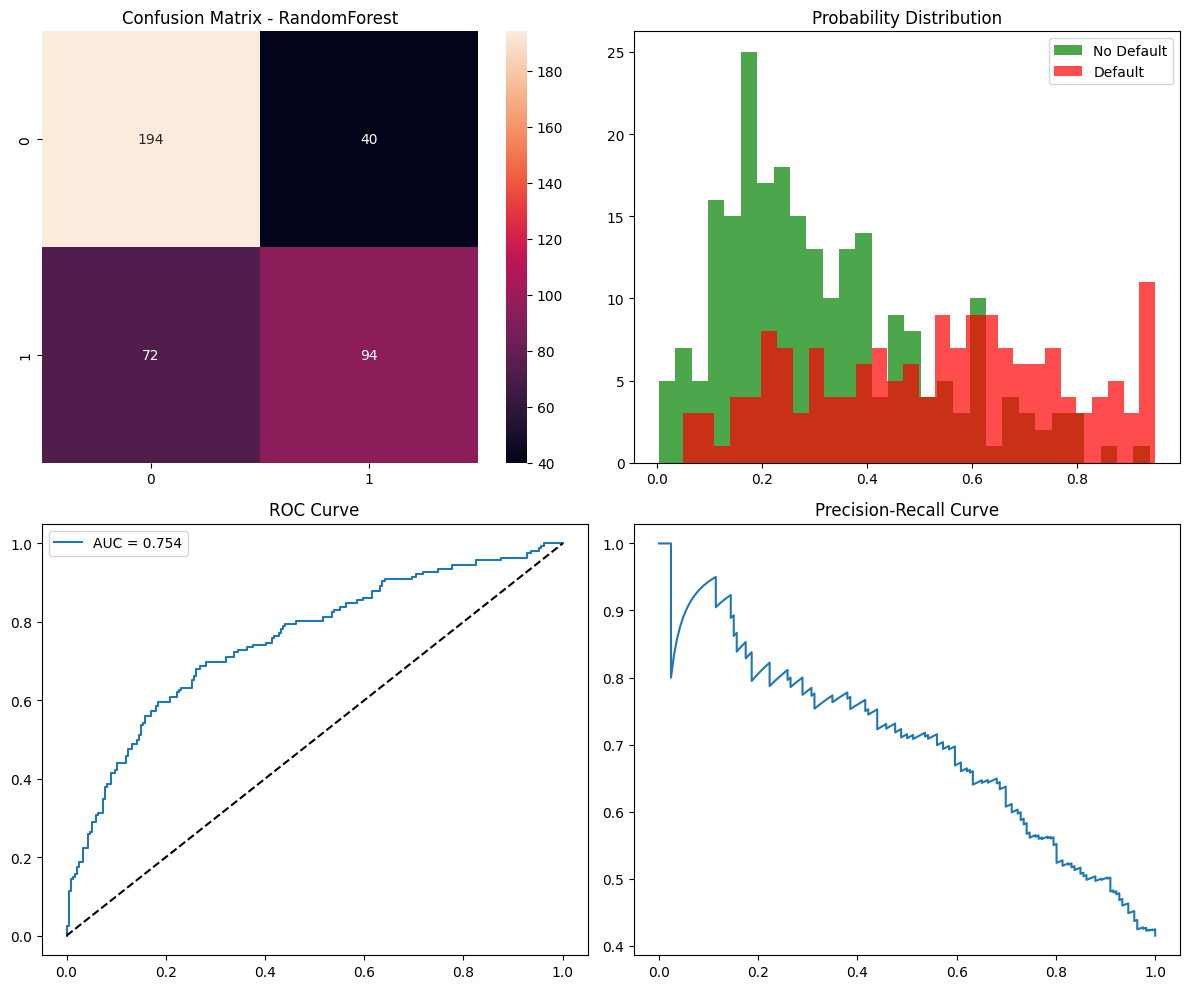

✅ RandomForest - Accuracy: 0.720, AUC: 0.754, Business Cost: 760.0
✅ Modèle entraîné et loggé dans MLFlow!


In [12]:
# Exemple d'utilisation simple
from sklearn.ensemble import RandomForestClassifier

# Entraîner un modèle et le logger automatiquement
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

metrics = mlflow_tracker.log_experiment(
    model=rf_model,
    model_name="RandomForest",
    X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
    params={"n_estimators": 100, "max_depth": 10, "random_state": 42},
    tags={"baseline": "true"}
)

print(f"✅ Modèle entraîné et loggé dans MLFlow!")


2025/11/28 15:23:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 15:23:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


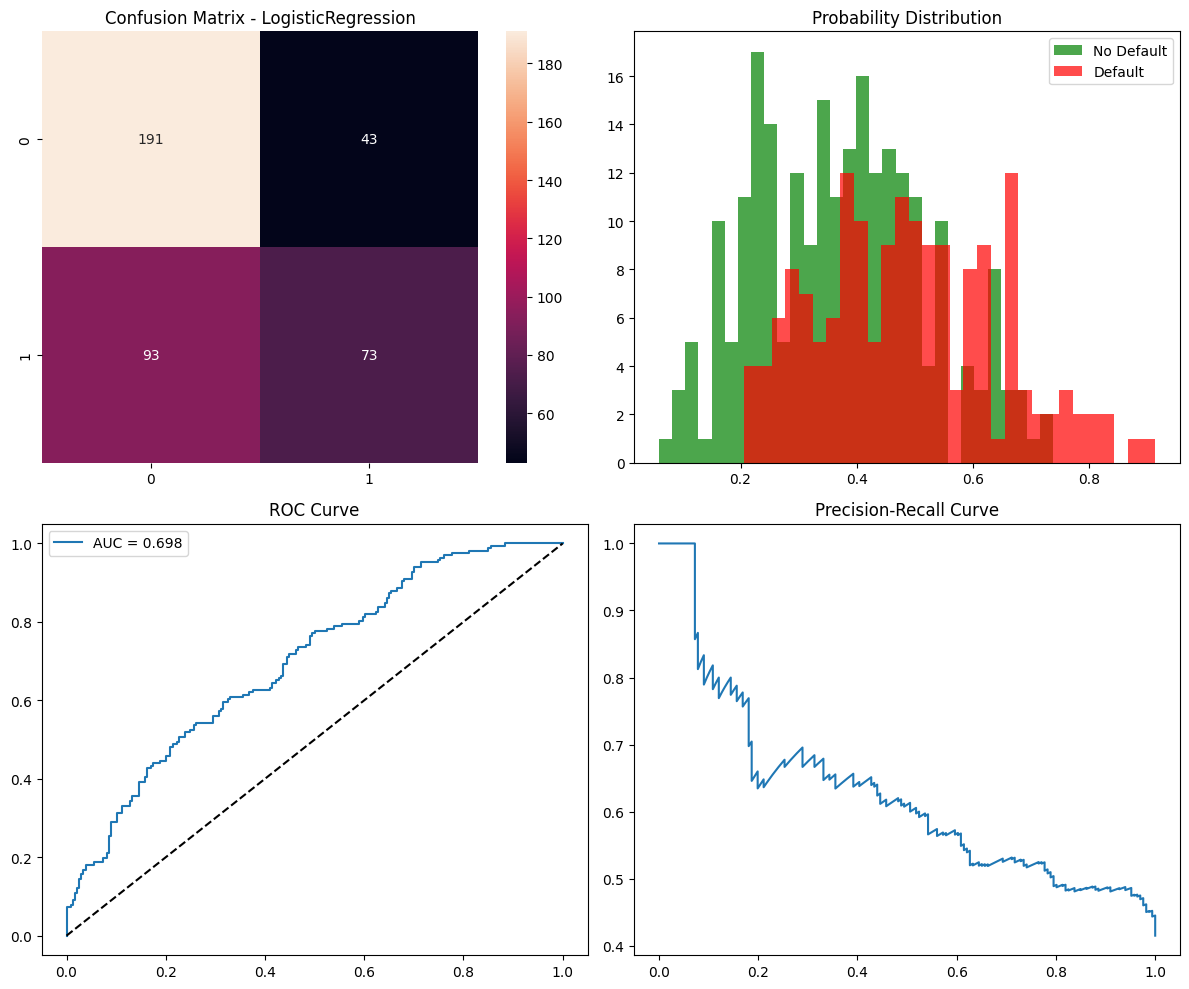

✅ LogisticRegression - Accuracy: 0.660, AUC: 0.698, Business Cost: 973.0


2025/11/28 15:23:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 15:23:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


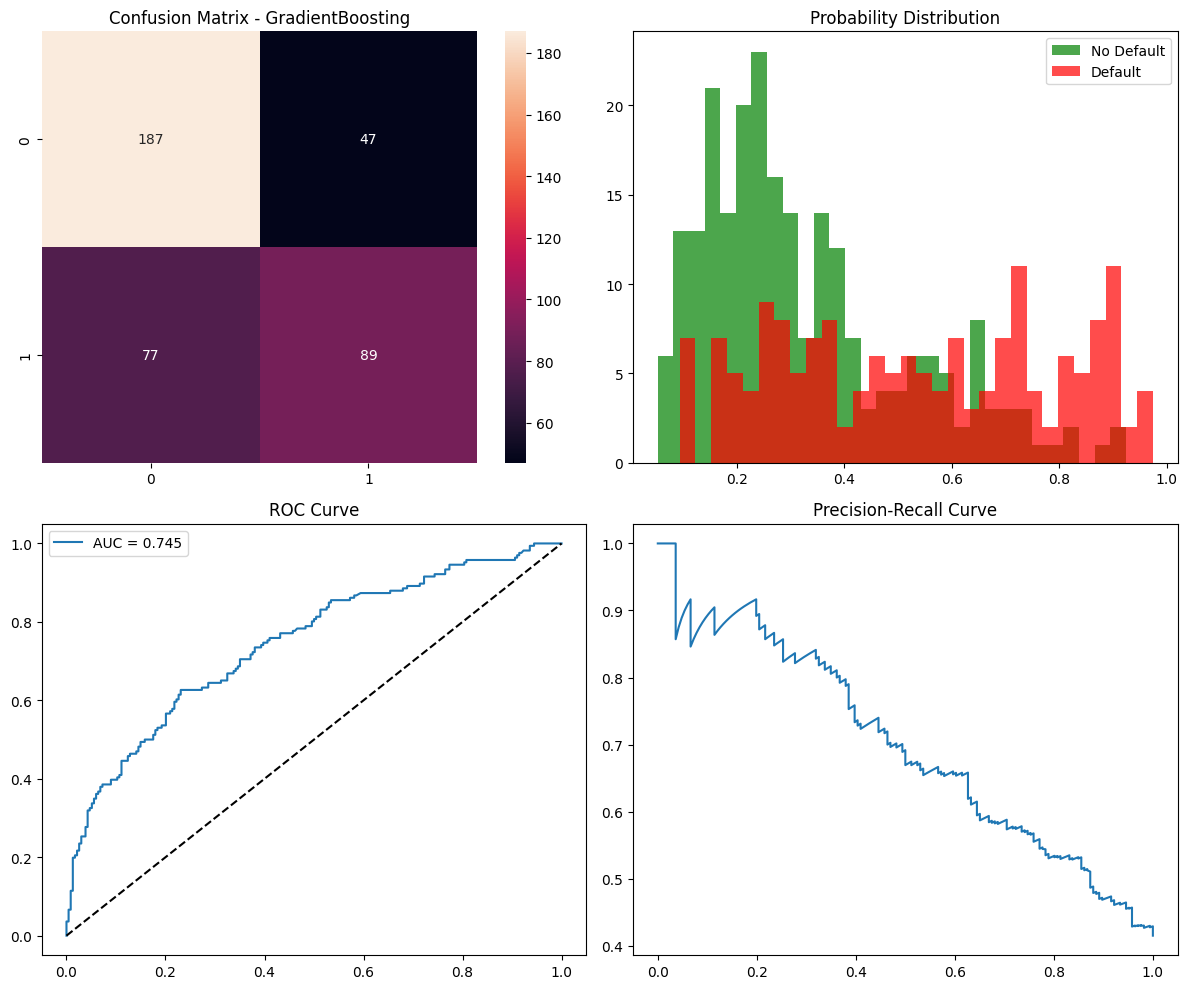

✅ GradientBoosting - Accuracy: 0.690, AUC: 0.745, Business Cost: 817.0

📊 Comparaison des modèles:
--------------------------------------------------------------------------------
Modèle               Accuracy   AUC        Business Cost  
--------------------------------------------------------------------------------
LogisticRegression   0.660      0.698      973.0          
GradientBoosting     0.690      0.745      817.0          

🏆 Meilleur modèle: GradientBoosting (Coût métier: 817.0)


In [13]:
# Comparaison de plusieurs modèles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

models_config = [
    {
        "model": LogisticRegression(random_state=42, max_iter=1000),
        "name": "LogisticRegression",
        "params": {"max_iter": 1000, "random_state": 42}
    },
    {
        "model": GradientBoostingClassifier(n_estimators=100, random_state=42),
        "name": "GradientBoosting",
        "params": {"n_estimators": 100, "random_state": 42}
    }
]

# Comparer tous les modèles
results = mlflow_tracker.compare_models(
    models_config, X_train, X_test, y_train, y_test
)


In [14]:
# Afficher les informations pour accéder à l'interface MLFlow
mlflow_tracker.show_ui_info()


🌐 Interface MLFlow disponible sur: http://localhost:5000
📊 Pour démarrer l'interface, exécutez dans le terminal:
   source .venv/bin/activate && mlflow ui

📈 Vous pouvez maintenant:
   - Voir toutes vos expérimentations
   - Comparer les métriques
   - Visualiser les graphiques
   - Télécharger les modèles
   - Gérer le registry des modèles
